**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: Proyecto Integrador -TC5035**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

Avance 2. Ingeniería de características

**- Equipo 37** <p>Perla Fernanda Bazán Barajas<p> Ignacio Garay Ruíz<p> David Cruz Beltrán

**- Matrículas** <p>A01420700<p> A01795753<p> A01360416

# Introducción

En la siguiente hoja se presenta el desarrollaron procesos de ingeniería de características con el fin de transformar el dataset original en un conjunto de variables optimizadas para el modelado con algoritmos de aprendizaje automático.
<p>
Respecto a la entrega anterior, el conjunto de datos fue ampliado y enriquecido, pasando de 331 a 824 registros, lo que representa una cobertura más amplia de campañas publicitarias y una base de información más robusta. Este crecimiento no solo mejora la representatividad de los patrones observados, sino que también fortalece la capacidad de generalización de los modelos a construir.
<p>
El mantenimiento de la misma estructura de 19 columnas permite dar continuidad al trabajo realizado en la primera fase, al tiempo que la mayor diversidad de ejemplos incrementa la solidez del análisis. Esta expansión del dataset constituye un paso clave para garantizar que los modelos resultantes capturen con mayor precisión las dinámicas visuales y creativas de las campañas, favoreciendo un desempeño más estable y confiable en la automatización de layouts multiformato.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# Aquí cada quien tiene que agregar el acceso directo de su carpeta compartida a su unidad de Drive
# Después poner la ruta correcta dependiendo del paso anterior
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/14. Proyecto integrador/Banners/CSV"
os.chdir(DIR)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("banners_metadata_3.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file              824 non-null    object 
 1   layer_name        824 non-null    object 
 2   type              824 non-null    object 
 3   priority          824 non-null    int64  
 4   x                 824 non-null    int64  
 5   y                 824 non-null    int64  
 6   width             824 non-null    int64  
 7   height            824 non-null    int64  
 8   z_index           824 non-null    int64  
 9   canvas_width      824 non-null    int64  
 10  canvas_height     824 non-null    int64  
 11  kv_canvas_width   694 non-null    float64
 12  kv_canvas_height  694 non-null    float64
 13  kv_x              600 non-null    float64
 14  kv_y              600 non-null    float64
 15  kv_width          600 non-null    float64
 16  kv_height         600 non-null    float64
 1

# **Parte 1. Preprocesamiento**

### **Creación de nuevas características**

De acuerdo con Galli (2022), la ingeniería de características no siempre consiste en añadir información externa, sino en crear representaciones derivadas de los datos crudos que reflejan factores más relevantes para el problema de negocio. Así como en credit scoring se agregan variables agregadas como la deuda total para capturar el nivel de riesgo global del cliente, en nuestro caso se agregan ``area_rel`` y ``aspect_ratio`` para capturar propiedades geométricas clave de los elementos de diseño. Aunque provienen de ``width`` y ``height``, estas nuevas características aportan una visión directa del peso visual (área ocupada) y de la forma (orientación horizontal/vertical) de los elementos, lo cual puede ser determinante en la calidad de los layouts generados.

Adicionalmente, se incorporó la columna ``is_in_kv``, que funciona como un indicador binario para señalar si un elemento existe en el Key Visual original o si fue agregado únicamente en el banner adaptado. Esto permite al modelo distinguir entre valores ausentes genuinos (elementos inexistentes en el KV) y valores válidos iguales a cero, evitando confusiones y preservando la semántica de los datos.

In [ ]:
# Agregamos las nuevas variables para los banners, que en este caso siempre van a existir
df["aspect_ratio"] = df["width"] / df["height"]
df["relative_area"] = (df["width"] * df["height"]) / (df["canvas_width"] * df["canvas_height"])

# Aspect ratio y área relativa en el KV (solo si is_in_kv = 1, sino NaN)
df["kv_aspect_ratio"] = np.where(
    df["is_in_kv"] == 1,
    df["kv_width"] / df["kv_height"],
    np.nan
)

df["kv_relative_area"] = np.where(
    df["is_in_kv"] == 1,
    (df["kv_width"] * df["kv_height"]) / (df["kv_canvas_width"] * df["kv_canvas_height"]),
    np.nan
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file              824 non-null    object 
 1   layer_name        824 non-null    object 
 2   type              824 non-null    object 
 3   priority          824 non-null    int64  
 4   x                 824 non-null    int64  
 5   y                 824 non-null    int64  
 6   width             824 non-null    int64  
 7   height            824 non-null    int64  
 8   z_index           824 non-null    int64  
 9   canvas_width      824 non-null    int64  
 10  canvas_height     824 non-null    int64  
 11  kv_canvas_width   694 non-null    float64
 12  kv_canvas_height  694 non-null    float64
 13  kv_x              600 non-null    float64
 14  kv_y              600 non-null    float64
 15  kv_width          600 non-null    float64
 16  kv_height         600 non-null    float64
 1

# Datos Faltantes y su Relación con los Key Visuals


Al explorar el conjunto de datos actualizado, se observa la presencia de valores faltantes.<p>

Estos datos ausentes tienen una justificación lógica dentro del proceso de construcción del dataset. Como se mencionó en la entrega anterior, no todos los banners analizados cuentan con un key visual de referencia del cual hayan sido adaptados. En varios casos, el archivo fuente proviene de campañas que no utilizaron un KV explícito, o bien, no fue posible extraerlo al momento de consolidar los datos.<p>

Adicionalmente, aunque algunas campañas sí disponen de un KV, no todos los elementos visibles en los banners se encuentran representados dentro del mismo. Esto se debe a que los banners suelen incorporar componentes adicionales —como llamados a la acción (CTAs), textos promocionales o íconos específicos— que no están presentes en el arte maestro. Este fenómeno responde a la función particular de cada pieza adaptada, que puede requerir personalización según el formato, el canal de distribución o los objetivos puntuales de la campaña.
<p>
Por lo tanto, la presencia de datos faltantes en estas columnas no es resultado de un error en la recopilación, sino una característica inherente al proceso creativo y adaptativo de las campañas publicitarias. Esta particularidad será tomada en cuenta al momento de diseñar las transformaciones y los modelos predictivos, para asegurar que el sistema sea capaz de operar con datos incompletos y manejar excepciones de forma robusta.

In [ ]:
# Determina el porcentaje de valores faltantes por columna
missing_values = df.isnull().mean() * 100
missing_values

,0
file,0.000000
layer_name,0.000000
type,0.000000
priority,0.000000
x,0.000000
y,0.000000
width,0.000000
height,0.000000
z_index,0.000000
canvas_width,0.000000


# Análisis de la Distribución de Variables

Como parte del análisis exploratorio y la preparación de los datos para su uso en modelos de aprendizaje automático, se procedió a examinar la distribución estadística de las variables numéricas del conjunto de datos.

Para ello, se generaron gráficos Q-Q (Quantile-Quantile), los cuales permiten comparar visualmente la distribución empírica de cada variable con una distribución normal teórica. Esta técnica resulta útil para identificar asimetrías, sesgos o valores atípicos, y es clave para fundamentar decisiones posteriores como la transformación de variables o la selección de algoritmos sensibles a la normalidad de los datos.

Este análisis ofrece una visión más profunda sobre el comportamiento de las variables y permite determinar si es necesario aplicar transformaciones (logarítmica, raíz cuadrada, Box-Cox, etc.) para aproximarlas a una distribución normal, con el fin de mejorar la estabilidad, interpretabilidad y rendimiento de los modelos.

In [ ]:
variables = ['x', 'y', 'width', 'height',
       'canvas_width', 'canvas_height', 'kv_canvas_width',
       'kv_canvas_height', 'kv_x', 'kv_y', 'kv_width', 'kv_height',
       'aspect_ratio', 'relative_area',
       'kv_aspect_ratio', 'kv_relative_area']

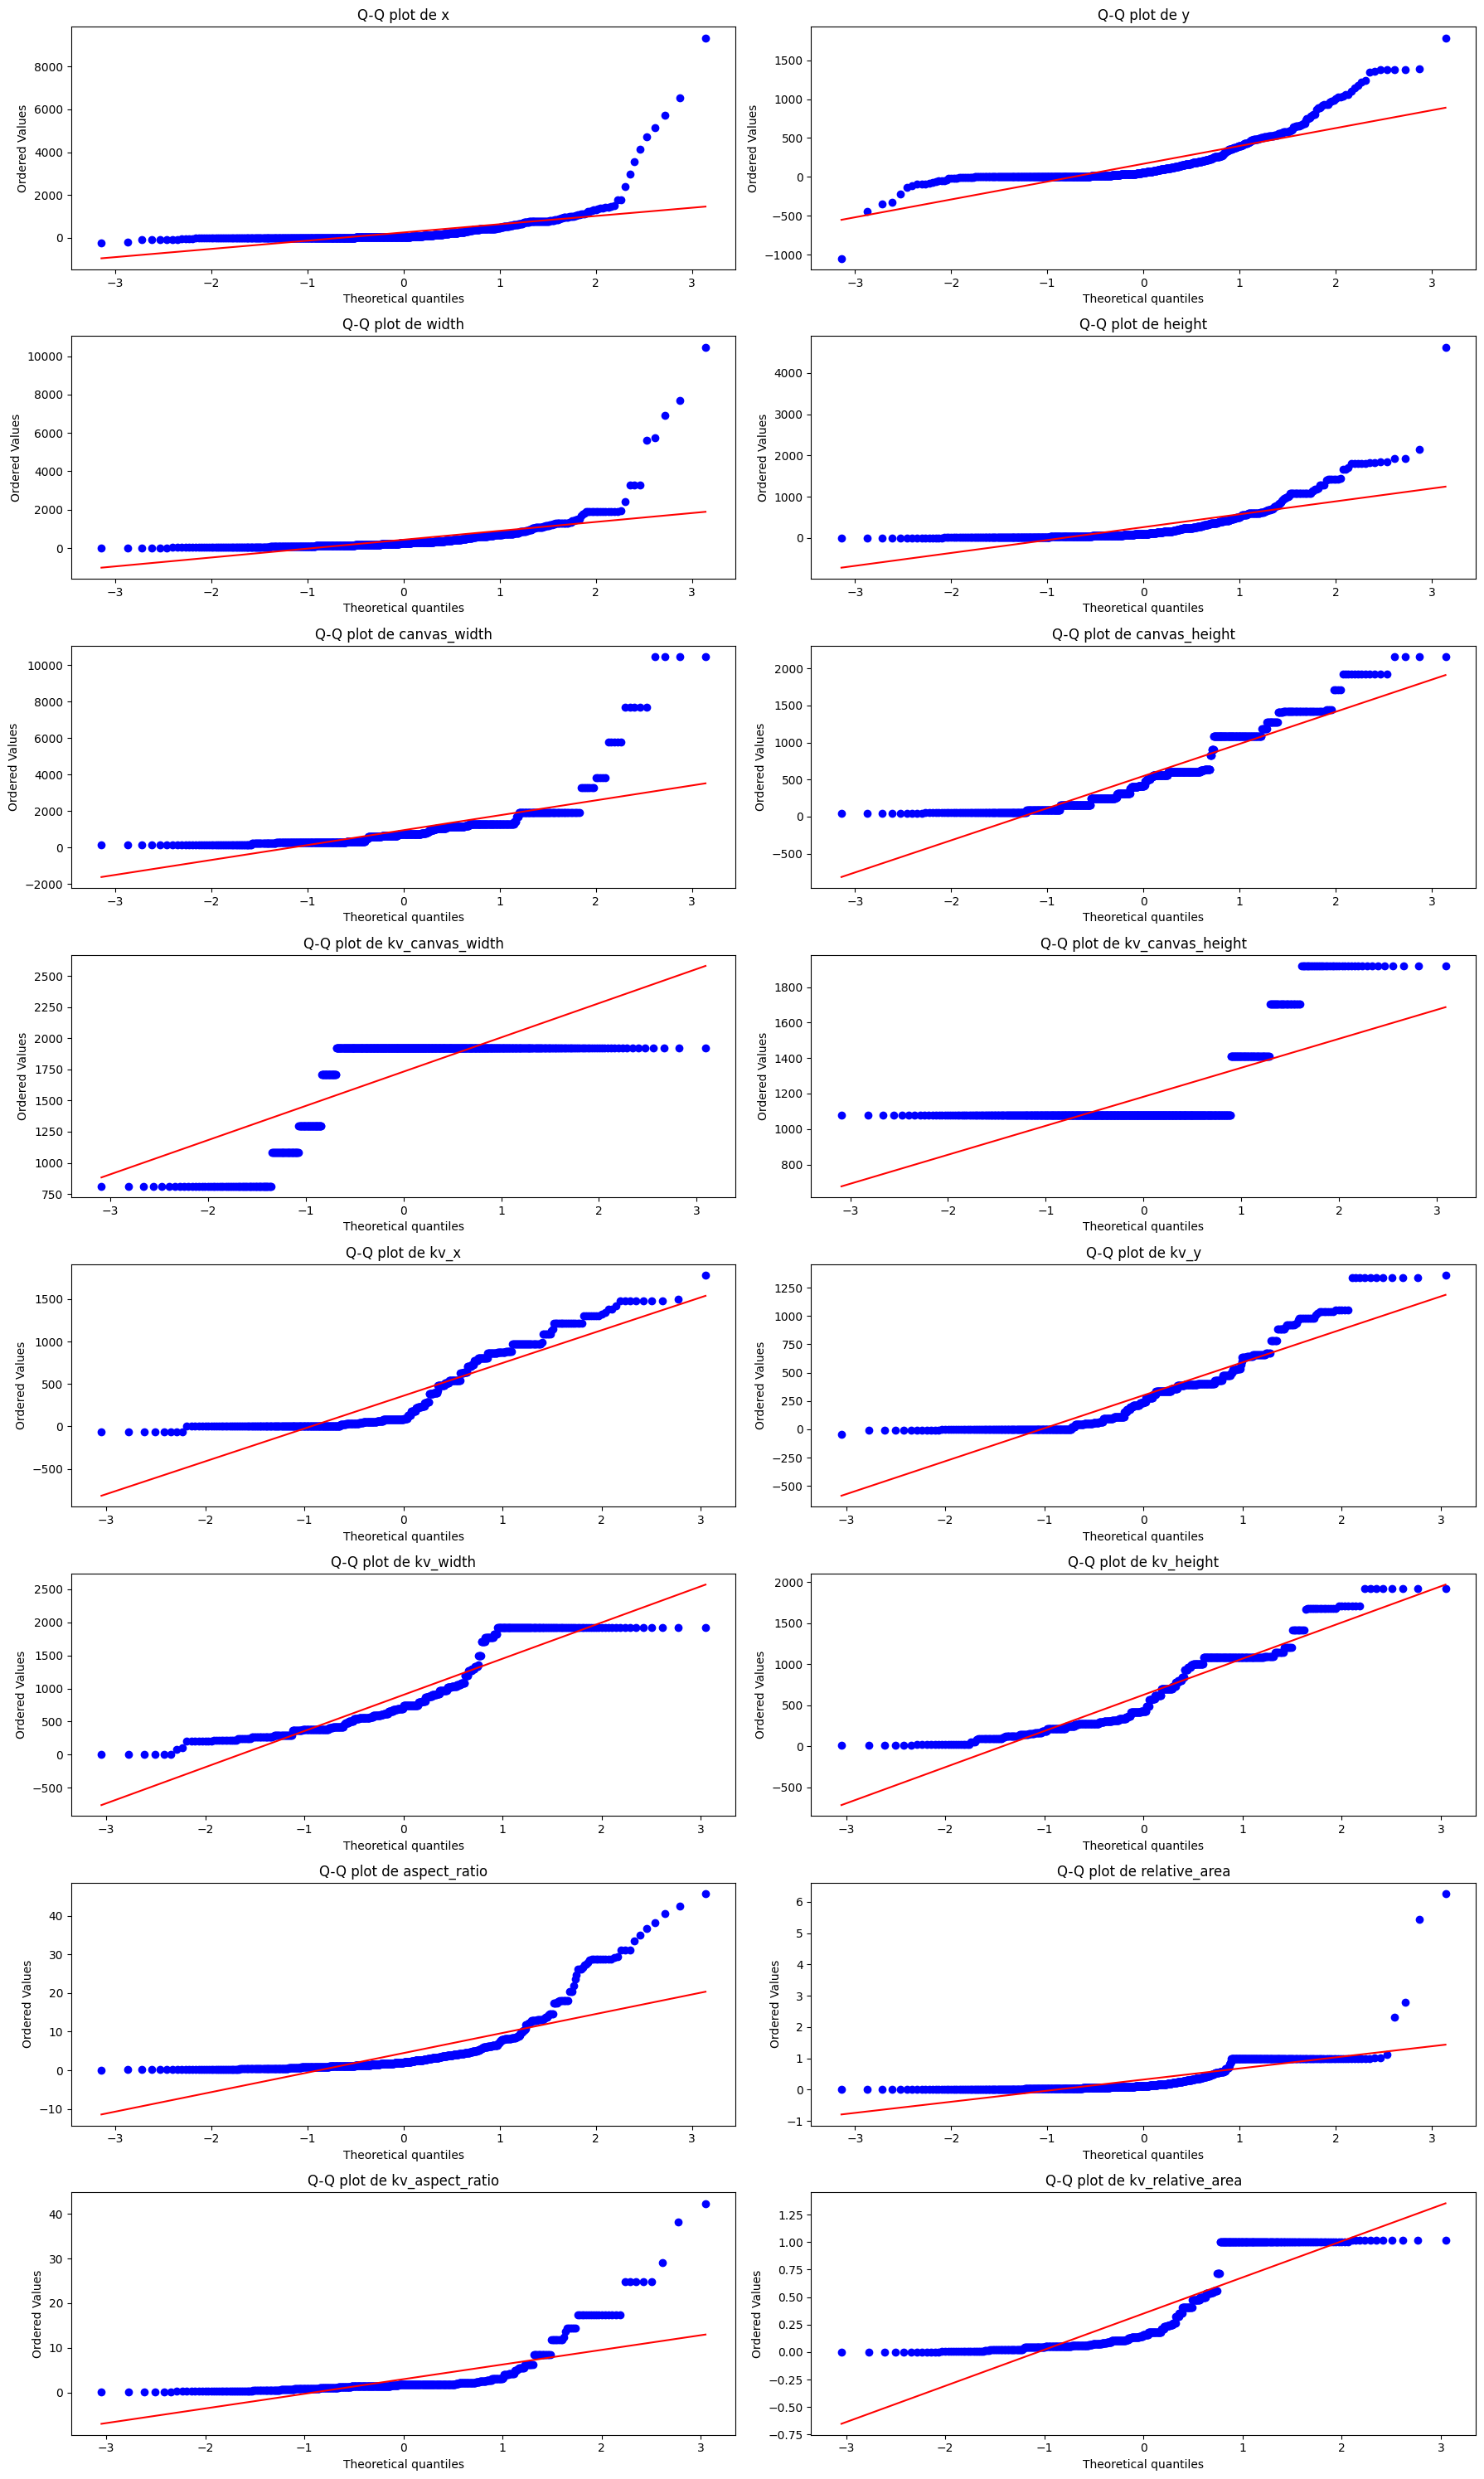

In [ ]:
plt.figure(figsize=(18, 30))
for i, col in enumerate(variables, 1):
    plt.subplot(8, 2, i)
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"Q-Q plot de {col}")

plt.tight_layout()
plt.show()

### Resultado del análisis

El análisis Q-Q permitió evaluar la distribución de las principales variables numéricas y decidir la pertinencia de aplicar transformaciones previas al escalamiento. Los hallazgos fueron los siguientes:
<p>
Variables geométricas absolutas (x, y, width, height y sus equivalentes en KV):
Se identificaron distribuciones alejadas de la normalidad, sin embargo, no se aplicaron transformaciones Box-Cox o Yeo-Johnson, ya que estas variables representan posiciones y dimensiones espaciales que son fundamentales para preservar la semántica de los banners. Alterarlas podría distorsionar la interpretación geométrica de los layouts. En el caso de las variables del KV, se mantienen en su escala original al formar parte de las variables objetivo del modelo.
<p>
Variables de canvas (canvas_width, canvas_height, kv_canvas_width, kv_canvas_height):
Presentan una naturaleza discretizada asociada a formatos predefinidos de banner (ej. 1080x1080, 1200x628, etc.). Debido a esta discreción estructural, transformarlas no sería adecuado, ya que perderían su valor representativo como categorías implícitas. Se plantea la posibilidad de tratarlas como variables categóricas en etapas posteriores, especialmente cuando se cuente con un número mayor de ejemplos que cubran distintos formatos de banners.
<p>
Variables derivadas (aspect_ratio, relative_area y sus equivalentes en KV):
Estas variables presentan un sesgo positivo pronunciado, con concentración de valores bajos y colas largas hacia la derecha. Para mejorar su distribución y favorecer la estabilidad de los algoritmos de aprendizaje, se recomienda aplicar transformaciones como Yeo-Johnson, que admite ceros y suaviza este tipo de asimetrías. Esto permitirá un escalamiento más homogéneo y reducirá el riesgo de que valores extremos dominen el entrenamiento.

In [ ]:
transf_df = df.copy()

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer

In [ ]:
variables_trans = ['aspect_ratio', 'relative_area', 'kv_aspect_ratio', 'kv_relative_area']
transformer = PowerTransformer(method="yeo-johnson", standardize=False)

In [ ]:
transformer.fit(transf_df[variables_trans])

PowerTransformer(standardize=False)

In [ ]:
transformer.lambdas_

array([-0.5350246 , -3.2586386 , -0.80298156, -2.61230039])

In [ ]:
transf_df[variables_trans] = transformer.transform(transf_df[variables_trans])

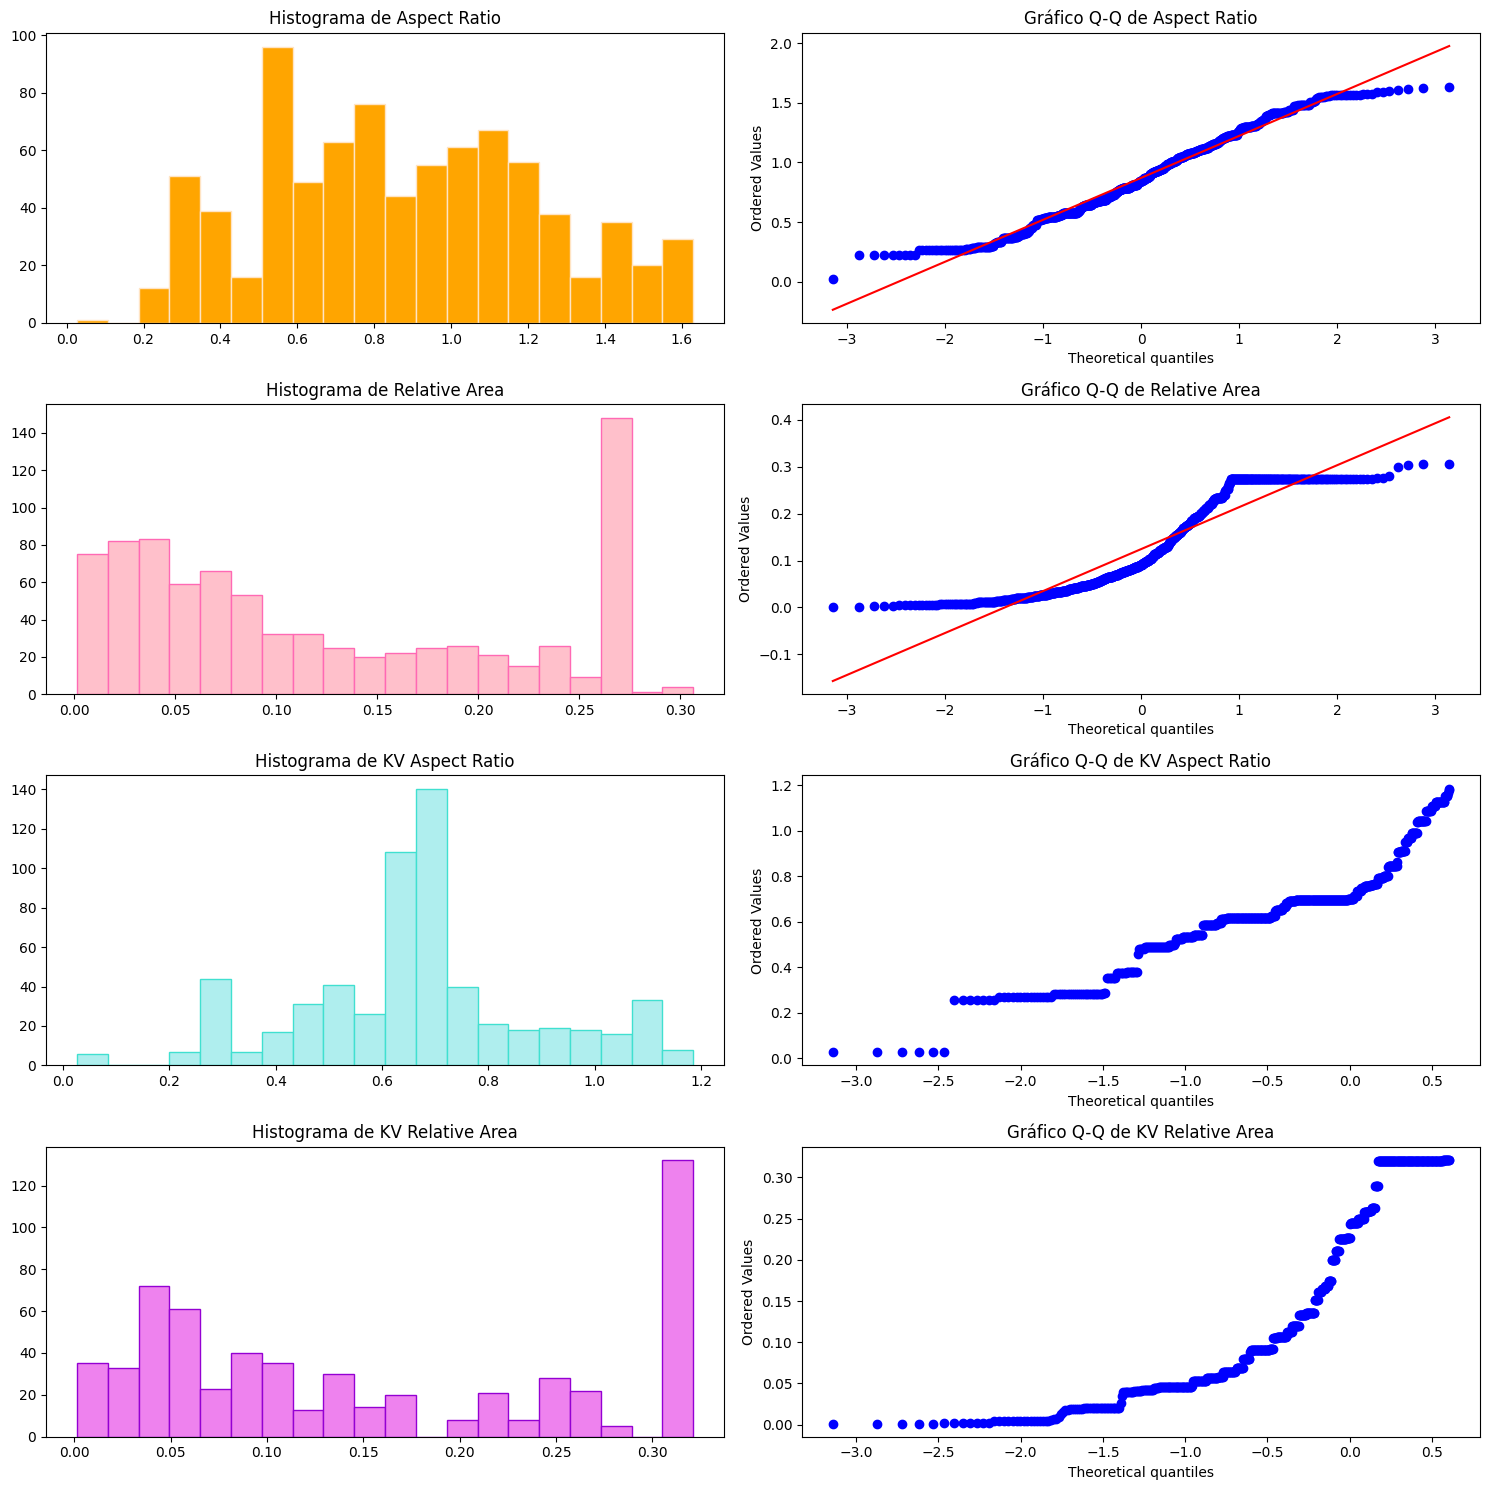

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(15, 15))
#Aspect ratio
#Histograma
axs[0, 0].hist(transf_df['aspect_ratio'], bins=20, color='orange', edgecolor='bisque')
axs[0, 0].set_title('Histograma de Aspect Ratio')
#Q-Q
stats.probplot(transf_df['aspect_ratio'], dist="norm", plot=axs[0, 1])
axs[0, 1].set_title('Gráfico Q-Q de Aspect Ratio')


#Relative Area
#Histograma
axs[1, 0].hist(transf_df['relative_area'], bins=20, color='pink', edgecolor='hotpink')
axs[1, 0].set_title('Histograma de Relative Area')
#Q-Q
stats.probplot(transf_df['relative_area'], dist="norm", plot=axs[1, 1])
axs[1, 1].set_title('Gráfico Q-Q de Relative Area')


#KV Aspect Ratio
#Histograma
axs[2, 0].hist(transf_df['kv_aspect_ratio'], bins=20, color='paleturquoise', edgecolor='turquoise')
axs[2, 0].set_title('Histograma de KV Aspect Ratio')
#Q-Q
stats.probplot(transf_df['kv_aspect_ratio'], dist="norm", plot=axs[2, 1])
axs[2, 1].set_title('Gráfico Q-Q de KV Aspect Ratio')

#KV Relative Area
#Histograma
axs[3, 0].hist(transf_df['kv_relative_area'], bins=20, color='violet', edgecolor='darkviolet')
axs[3, 0].set_title('Histograma de KV Relative Area')
#Q-Q
stats.probplot(transf_df['kv_relative_area'], dist="norm", plot=axs[3, 1])
axs[3, 1].set_title('Gráfico Q-Q de KV Relative Area')

plt.tight_layout()
plt.show()

Viendo los histogramas y los Q-Q plots:

- Aspect Ratio: quedó bastante más centrado, con menos sesgo. El Q-Q plot se aproxima más a la diagonal, es decir, transformación efectiva.

- Relative Area: también mejoró, aunque se siguen viendo algunos escalones por la naturaleza discreta del cálculo (relación con tamaños de canvas).

- KV Aspect Ratio y KV Relative Area: mostraban sesgo fuerte antes. Tras la transformación se suavizó, pero siguen alejados de la normalidad perfecta. Esto es esperable porque los datos provienen de composiciones de diseño (no son fenómenos naturales gaussianos).

Conclusión: las transformaciones son adecuadas y mejoran la distribución, aunque no buscan perfección normal sino reducir sesgo para facilitar el aprendizaje del modelo.

## Escalamiento MinMax

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from IPython.display import display, HTML

In [ ]:
variables_minmax = ['x', 'y', 'width', 'height',
       'kv_x', 'kv_y', 'kv_width', 'kv_height',
       'aspect_ratio', 'relative_area',
       'kv_aspect_ratio', 'kv_relative_area']

In [ ]:
minmax_df = transf_df[variables_minmax].copy()
scaler = MinMaxScaler()
minmax_df[variables_minmax] = scaler.fit_transform(transf_df[variables_minmax])
html = minmax_df.head().to_html(index=False, classes='table table-striped')
display(HTML(html))

x,y,width,height,kv_x,kv_y,kv_width,kv_height,aspect_ratio,relative_area,kv_aspect_ratio,kv_relative_area
0.026384,0.369220,0.162235,0.368080,0.033641,0.029957,0.887958,0.888017,0.344622,0.896443,0.435912,0.996724
0.066117,0.842570,0.086091,0.030709,0.240369,0.986448,0.471204,0.071690,0.744790,0.131543,0.832599,0.127277
0.044322,0.446523,0.129233,0.034170,0.126967,0.186163,0.707330,0.080063,0.797736,0.208409,0.874271,0.203404
0.050579,0.553830,0.120815,0.122405,0.159523,0.402996,0.661257,0.293564,0.526992,0.514396,0.633115,0.523300
0.026384,0.369220,0.123206,0.232699,0.033641,0.029957,0.674346,0.560440,0.384971,0.896443,0.481695,0.996724


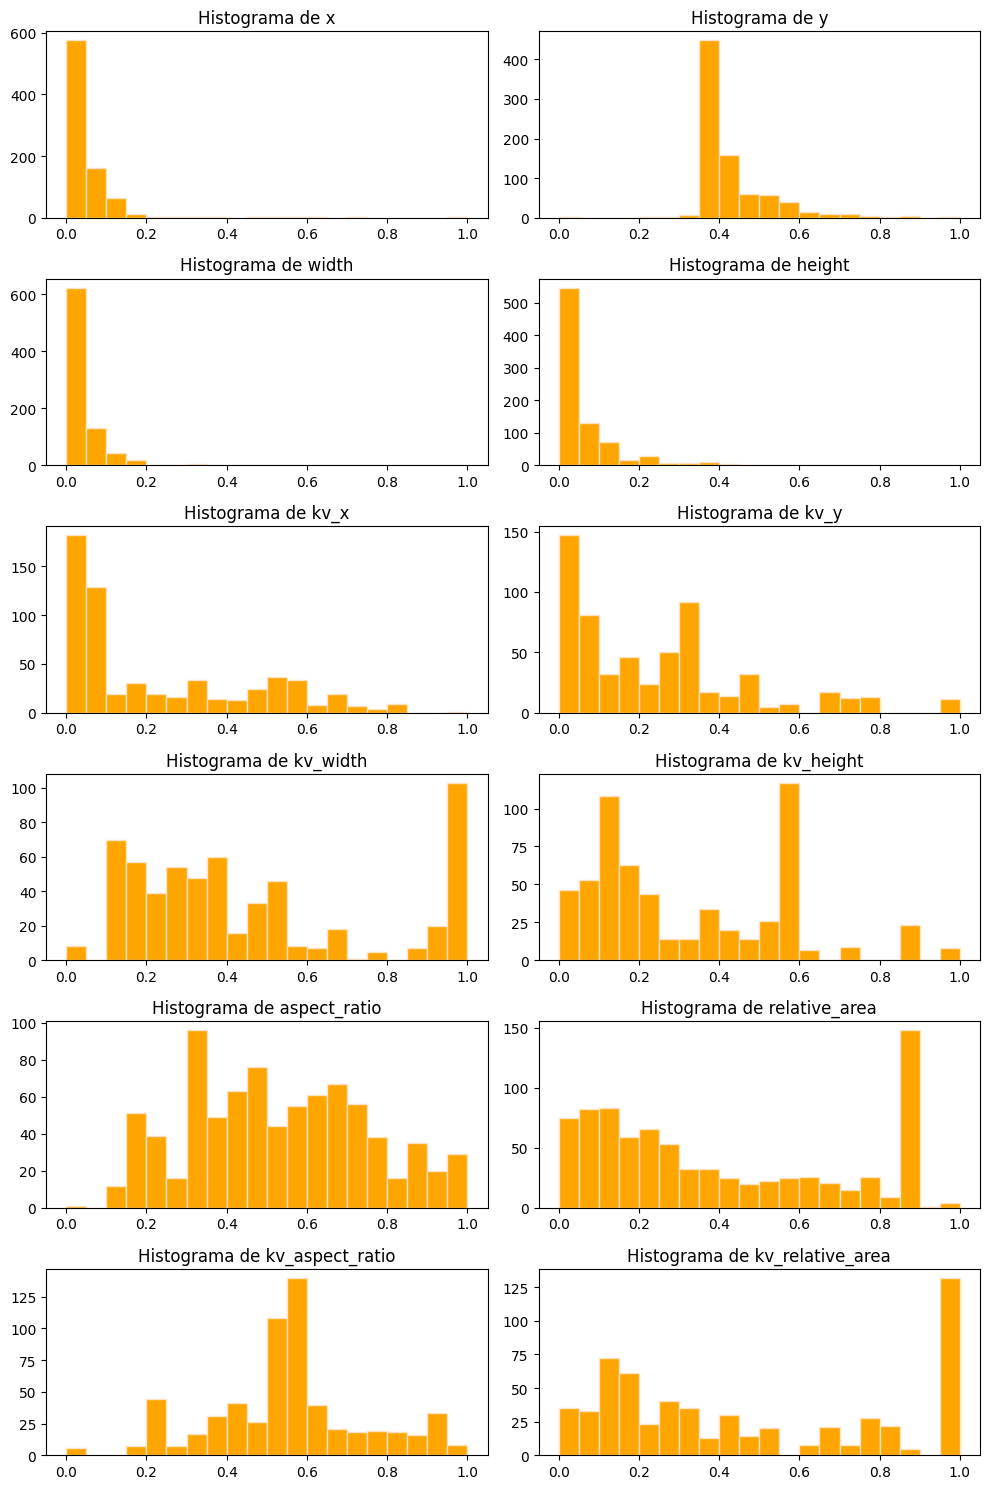

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(10, 15))
axs = axs.ravel()

for i, col in enumerate(variables_minmax):
    axs[i].hist(minmax_df[col], bins=20, color='orange', edgecolor='bisque')
    axs[i].set_title(f'Histograma de {col}')

plt.tight_layout()
plt.show()

El escalamiento Min-Max permitió homogeneizar las variables en un rango comparable, eliminando sesgos por magnitud. Si bien las distribuciones continúan sesgadas o discretizadas, esto refleja la naturaleza del problema (patrones de diseño gráfico). La normalización no busca forzar una forma gaussiana, sino garantizar que todas las variables estén en una misma escala para mejorar la convergencia de los algoritmos y evitar que alguna domine sobre las demás por tener un rango mayor.

# Codificando variables categóricas

In [ ]:
categorical_summary = df.describe(include='O')
html = categorical_summary.to_html(classes='table table-striped')
display(HTML(html))

categorical_summary.shape

,file,layer_name,type
count,824,824,824
unique,148,10,8
top,FoodService_KV.psd,COPY,TEXT
freq,9,180,241


(4, 3)

# Justificación variables categóricas

La columna ``file`` corresponde a un identificador único de cada arte o banner, por lo que presenta alta cardinalidad y carece de un significado semántico directo para la predicción. Existen técnicas de transformación para variables de este tipo (label encoding, frequency encoding, target encoding o embeddings), pero en este caso no resultan convenientes: podrían introducir orden ficticio, redundancia o incluso riesgo de data leakage al permitir que el modelo memorice patrones específicos de un archivo en lugar de generalizar sobre la disposición de los elementos. Por ello, se decidió no transformar file como feature y conservarla únicamente como metadato auxiliar. Esto asegura la trazabilidad del dataset y permite que, en la partición de train/test, todos los elementos derivados de un mismo archivo permanezcan en el mismo conjunto, evitando fugas de información y manteniendo la validez del proceso de entrenamiento.

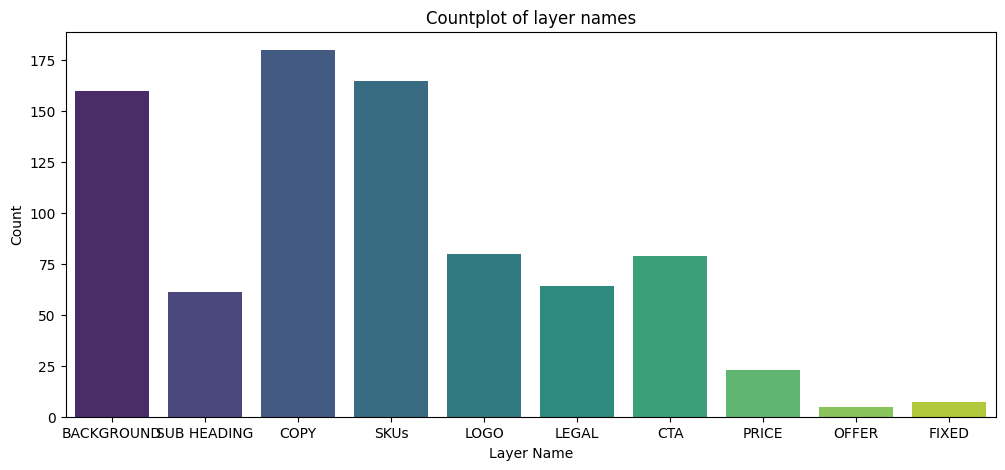

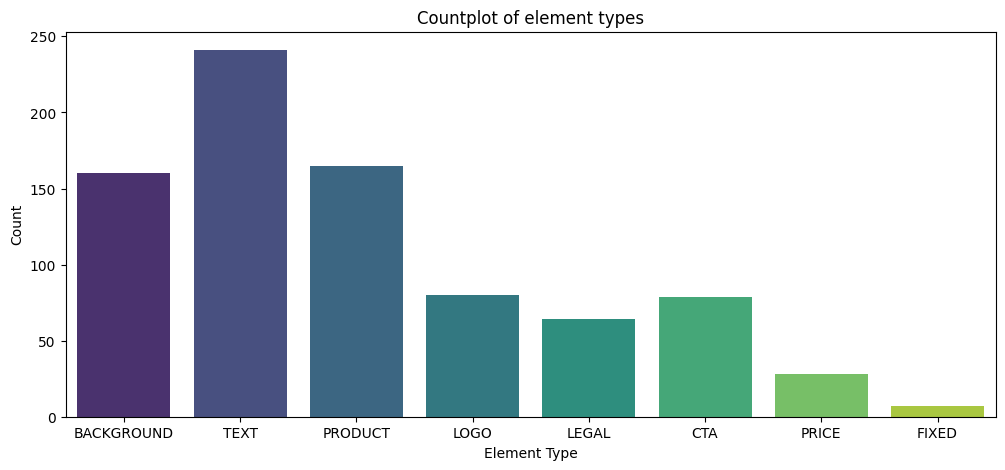

In [ ]:
variables_cat = ['layer_name','type']

plt.figure(figsize=(12, 5))
ax1 = sns.countplot(x=variables_cat[0], data=df, hue=variables_cat[0], palette='viridis')

plt.title('Countplot of layer names')
plt.xlabel('Layer Name')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 5))
ax1 = sns.countplot(x=variables_cat[1], data=df, hue= variables_cat[1], palette='viridis')

plt.title('Countplot of element types')
plt.xlabel('Element Type')
plt.ylabel('Count')
plt.show()

# Análisis de Variables Categóricas

En esta sección se analizan dos variables categóricas clave del conjunto de datos: layer_name y type.

layer_name representa el nombre o rol específico de cada capa dentro del banner (por ejemplo: COPY, LOGO, CTA), lo que refleja su propósito funcional y ubicación típica dentro del diseño.

type corresponde al tipo general de contenido visual de la capa, clasificado en categorías como TEXT, PRODUCT, BACKGROUND, entre otros.
<p>
Ambas variables aportan información semántica relevante sobre el rol y la naturaleza de los elementos en el diseño visual. Por ejemplo, un LOGO o un BACKGROUND tienden a comportarse de manera distinta en términos de posición, tamaño o prioridad visual en comparación con un CTA (Call to Action). A diferencia de columnas como file, estas variables sí guardan una relación directa con la tarea de predicción, ya que podrían influir en cómo el modelo aprende a distribuir los elementos en un banner adaptado.
<p>
Para visualizar la frecuencia de estas categorías, se generaron gráficos de barras (countplots). En el caso de layer_name, se observa una alta presencia de capas como COPY, BACKGROUND y SKUs, lo cual es coherente con la estructura típica de un banner publicitario. En type, predominan los elementos TEXT, PRODUCT y BACKGROUND, lo que refuerza la importancia de estos tipos en el diseño visual.

### Justificación

Dado que ambas variables contienen un número reducido de categorías (7–8 cada una) y no existe un orden natural entre sus clases, se optó por aplicar codificación one-hot (one-hot encoding). Esta técnica es adecuada para variables nominales, ya que:

Evita la introducción de relaciones ordinales artificiales, como podría suceder con técnicas como label encoding.

Preserva la interpretabilidad del modelo, permitiendo que cada categoría se represente como una variable binaria independiente.

Facilita el aprendizaje en modelos lineales y redes neuronales, al no inducir sesgos no deseados en las relaciones entre clases.

En resumen, esta transformación permite al modelo capturar la influencia diferenciada de cada tipo de capa y elemento visual, mejorando así su capacidad de generalización y precisión en la tarea de predicción de layouts publicitarios.

Una de las prnicipales ventajes que también nos ofrece el método one hot es la flexibilidad en cuannto al manejo de nuevos datos que puedan añadirse al data frame, ya que no modificaría la estructura semmántica original del modelo. Adicional, esta técnica facilita la integración de variables como entradas numéricas sin requerir de ajustes adicionales.

In [ ]:
onehot_df = pd.get_dummies(df[variables_cat], drop_first=True) # Codificación one-hot
print(f'Shape de la transformación: {onehot_df.shape}')

Shape de la transformación: (824, 16)


In [ ]:
onehot_df = onehot_df.astype(int)
onehot_df

,layer_name_COPY,layer_name_CTA,layer_name_FIXED,layer_name_LEGAL,layer_name_LOGO,layer_name_OFFER,layer_name_PRICE,layer_name_SKUs,layer_name_SUB HEADING,type_CTA,type_FIXED,type_LEGAL,type_LOGO,type_PRICE,type_PRODUCT,type_TEXT
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
821,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
822,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# **Conclusiones**

Durante esta etapa de ingeniería de características, se avanzó significativamente en la preparación del conjunto de datos para su uso en modelos de aprendizaje automático, específicamente enfocados en la automatización de layouts publicitarios adaptativos.
<p>
Se amplió el volumen de datos analizados, lo que permitió una representación más robusta de las distintas categorías de capas (layer_name) y tipos de elementos (type) presentes en los banners. Este enriquecimiento fortalece la base para que el modelo logre una mejor capacidad de generalización.
<p>
El análisis de las variables categóricas reveló patrones consistentes con la lógica del diseño publicitario, como la alta frecuencia de elementos de texto y productos, reafirmando su relevancia como características predictivas clave. Para optimizar su uso, se aplicó codificación one-hot en aquellas sin orden natural, garantizando interpretabilidad y evitando relaciones artificiales entre clases.
<p>
En el caso de las variables numéricas, se evaluó su distribución mediante gráficos Q-Q, identificando sesgos y colas largas que orientan la necesidad de aplicar transformaciones específicas (como Yeo-Johnson en variables derivadas). Estas decisiones contribuyen a un escalamiento más equilibrado, favoreciendo la convergencia de los algoritmos en fases posteriores.
<p>
Se identificaron valores faltantes en columnas relacionadas con los key visuals, explicados por la naturaleza creativa del proceso de diseño, donde no siempre existe una correspondencia directa entre elementos adaptados y el arte original. Este hallazgo permitirá definir estrategias de imputación o exclusión en futuras etapas.
<p>
Adicionalmente, se incorporó la variable price, lo que amplía el horizonte analítico al incluir un factor de negocio que conecta el rendimiento creativo con métricas económicas. Esta inclusión permitirá explorar relaciones entre atributos visuales y valor comercial, enriqueciendo la perspectiva del modelo hacia objetivos más integrales.
<p>
En conjunto, estos avances consolidan la estructura semántica y numérica del dataset, garantizando que las siguientes fases del proyecto —modelado y evaluación— se realicen sobre datos de mayor calidad, mejor representados y alineados con los objetivos de negocio. De este modo, el modelo resultante estará mejor capacitado para comprender jerarquías visuales, estructuras comunes y comportamientos espaciales de los elementos gráficos, mientras incorpora dimensiones de valor comercial. Con ello, FlexSAIze avanza hacia su meta de automatizar de forma inteligente la adaptación de layouts multiformato para campañas publicitarias, aportando eficiencia operativa y coherencia estratégica.

# **Referencias**

- Galli, S. (2022). Python Feature Engineering Cookbook. Packt Publishing. https://learning.oreilly.com/library/view/python-feature-engineering/9781804611302/B18894_03.xhtmlLinks to an external site.

- Visengeriyeva, L., Kammer, A., Bär, I., Kniesz, A., y Plöd, M. (2023). CRISP-ML(Q). The ML Lifecycle Process. MLOps. INNOQ. https://ml-ops.org/content/crisp-ml